In [1]:
import numpy as np
import cv2
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import os
from tqdm import tqdm

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import classification_report

print(torch.__version__)
print(torch.cuda.is_available())

2.0.0+cpu
False


In [2]:
def preprocessing(path, minValue = 70):    
    frame = cv2.imread(path)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)

    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return res

(128, 128)


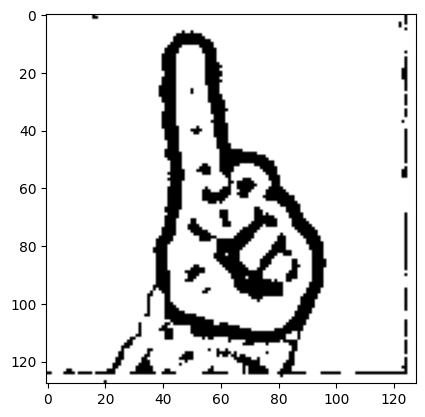

In [3]:
zeros = preprocessing('Sign Language images/1/0.jpg')
print(zeros.shape)
plt.imshow(zeros, cmap='gray')
plt.show()

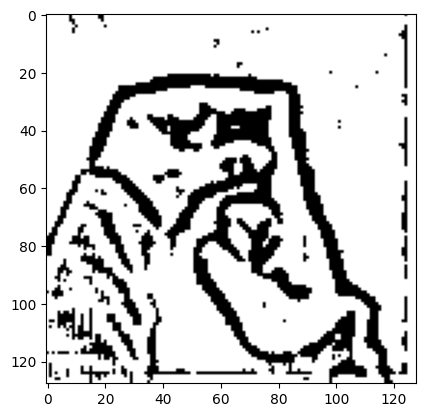

In [4]:
# Image Preprocessing
class Image_preprocessing():
    def __init__(self, minValue=70):
        #self.path = path
        self.minValue = minValue
    def image_preprocessing(self,img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray,(5, 5), 2)

        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        ret, res = cv2.threshold(th3, self.minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        return res

    def __call__(self, path):
        return self.image_preprocessing(path)

# Check
Path = 'Sign Language images/P/0.jpg'
img_preprocessing = Image_preprocessing()
img =Image.open(Path)
plt.imshow(img_preprocessing(img),cmap='gray')
plt.show()

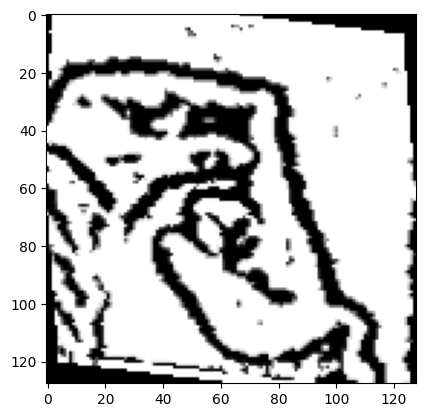

In [5]:
# Define the transforms to apply to the images
Transforms = transforms.Compose([
    Image_preprocessing(),
    transforms.ToPILImage(),
    # Random crop with zoom
    transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), ratio=(0.8, 1.2)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),   # Rotate the image randomly up to 30 degrees
    transforms.RandomAffine(degrees=0, shear=10),   # Apply affine transformation with shear up to 30 degrees
    transforms.ToTensor(),    # Convert the image to a tensor
    transforms.Normalize(mean=[0.5],
                         std=[0.5])  # Normalize the pixel values
     
])

Paths = 'Sign Language images/A/0.jpg'
img =Image.open(Path)
img_transformed = Transforms(img)
img_transformed.shape

plt.imshow(img_transformed.permute(1, 2, 0), cmap='gray')
plt.show()

In [71]:
Image_dirs = 'Sign Language images/'

# ImageFolder dataset for the full dataset
full_dataset = datasets.ImageFolder(Image_dirs, transform=Transforms)

# Split the dataset into training and testing sets
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = data.random_split(full_dataset, [train_size, test_size])

# Print the number of images in each set
print(f"Found {len(train_dataset)} images in the training set")
print(f"Found {len(test_dataset)} images in the testing set")

Found 31500 images in the training set
Found 10500 images in the testing set


In [72]:
# access the label with indices reverse the dictionay
# by key to value and value to key
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}
Labels_index

{0: '1',
 1: '2',
 2: '3',
 3: '4',
 4: '5',
 5: '6',
 6: '7',
 7: '8',
 8: '9',
 9: 'A',
 10: 'B',
 11: 'C',
 12: 'D',
 13: 'E',
 14: 'F',
 15: 'G',
 16: 'H',
 17: 'I',
 18: 'J',
 19: 'K',
 20: 'L',
 21: 'M',
 22: 'N',
 23: 'O',
 24: 'P',
 25: 'Q',
 26: 'R',
 27: 'S',
 28: 'T',
 29: 'U',
 30: 'V',
 31: 'W',
 32: 'X',
 33: 'Y',
 34: 'Z'}

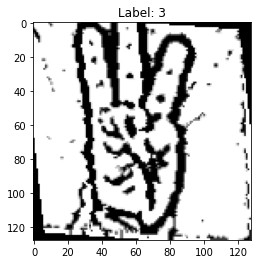

In [83]:
# Get the image and label from the dataset
index = 23000  # Change this to the index of the image you want to plot
image, label = train_dataset[index]

# Convert the image tensor to a numpy array and transpose it to the correct format
image = np.transpose(image.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {Labels_index[label]}")
plt.show()

In [84]:
class Sign_Language(nn.Module):
    def __init__(self):
        super(Sign_Language, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 35)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Sign_Language()

In [85]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
#model.to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

In [86]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the data loaders
batch_size = 500
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Train the model
num_epochs = 1

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    # Set the model to training mode
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        Max_val, pred_max_label =torch.max(outputs.data, 1)

     
        train_acc += (pred_max_label == labels).sum().item()            
        print('Image processesd{}',format(i*batch_size))
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move the data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update the test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
    
    # Print the epoch statistics
    print("Epoch {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch+1,
        train_loss, 
        train_acc, 
        test_loss, 
        test_acc))

Image processesd{} 0
Image processesd{} 500
Image processesd{} 1000
Image processesd{} 1500
Image processesd{} 2000
Image processesd{} 2500
Image processesd{} 3000
Image processesd{} 3500
Image processesd{} 4000
Image processesd{} 4500
Image processesd{} 5000
Image processesd{} 5500
Image processesd{} 6000
Image processesd{} 6500
Image processesd{} 7000
Image processesd{} 7500
Image processesd{} 8000
Image processesd{} 8500
Image processesd{} 9000
Image processesd{} 9500
Image processesd{} 10000
Image processesd{} 10500
Image processesd{} 11000
Image processesd{} 11500
Image processesd{} 12000
Image processesd{} 12500
Image processesd{} 13000
Image processesd{} 13500
Image processesd{} 14000
Image processesd{} 14500
Image processesd{} 15000
Image processesd{} 15500
Image processesd{} 16000
Image processesd{} 16500
Image processesd{} 17000
Image processesd{} 17500
Image processesd{} 18000
Image processesd{} 18500
Image processesd{} 19000
Image processesd{} 19500
Image processesd{} 20000

## Evaluation & Prediction

In [ ]:
# Set the model to evaluation mode
model.eval()

# Get the predicted labels and true labels for the test set
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted and true labels to the lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
# Generate the classification report
target_names = [Labels_index[i] for i in range(len(Labels))]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

In [ ]:
# Define the model file path
model_file = 'mymodel.pt'

# Save the model
torch.save(model, model_file)

In [ ]:
# Define the path to the saved model
path = "mymodel.pt"

# Load the model
Model = torch.load(path)
Model.to(device)

In [ ]:
img_path = 'Sign Language images/P/0.jpg'
img = Image.open(img_path)
# Apply the transform to the image
img = Transforms(img)
plt.imshow(img.permute(1, 2, 0))
img = img.to(device).unsqueeze(0)  # add batch dimension
print(img.shape)

# Pass the transformed image to the model
output = Model(img)
Max_val, label =torch.max(output.data, 1)
# Reverse the dictionary
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

plt.title('Actuel : {}\nPredicted :{}'.format(img_path.split('/')[-2],
                                       Labels_index[label.item()]))
plt.show()